In [1]:
from os import listdir
import numpy as np
from numpy import random

# nltk.download('opinion_lexicon')
import nltk
from nltk.corpus import opinion_lexicon
from nltk.tokenize import RegexpTokenizer

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
from sklearn.linear_model import LogisticRegression

In [2]:
# Set seed
SEED = 76
random.seed(76)

## Task a) 

Download the Pang and Lee movie review data: http://www.cs.cornell.edu/people/pabo/movie-review-data/ 


Hold out a randomly-selected 400 reviews as a test set. Download a sentiment lexicon, such as the one currently available from Bing Liu: https://www.cs.uic.edu/~liub/FBS/sentiment-analysis.html

In [3]:
# Load the data

pos_path = 'txt_sentoken/pos/'
neg_path = 'txt_sentoken/neg/'
pos_names = listdir(pos_path)
neg_names = listdir(neg_path)

pos_texts = []
for i in range(0, len(pos_names)):
    text = open(pos_path + pos_names[i], "r").read()
    pos_texts.append(text)
neg_texts = []
for j in range(0, len(neg_names)):
    text = open(neg_path + neg_names[i], "r").read()
    neg_texts.append(text)


In [4]:
# Combine the data with labels in numpy array
# Label positive as 1 and negative as 0
pos_label = 1
neg_label = 0

data = np.append(np.array([pos_texts, np.full((len(pos_texts)), pos_label)]).T,
          np.array([neg_texts, np.full((len(neg_texts)), neg_label)]).T, axis = 0)

# shuffle data

random.shuffle(data)
print(data[:,1][:10])

['1' '1' '0' '0' '1' '0' '0' '0' '0' '0']


#### Get sentiment lexicon

In [5]:
pos_set = set(opinion_lexicon.positive())
neg_set = set(opinion_lexicon.negative())

### i)

Tokenize the data using a library of your choosing and classify each document as
positive if it has more positive sentiment words than negative sentiment words.
Compute the accuracy and F-measure on detecting positive reviews on the test
set, using this lexicon-based classifier.

In [6]:
# Tokenize data by a regex tokenizer

tokenizer = RegexpTokenizer('\w+|\$[\d\.]+|\S+,')
tokenizer.tokenize(data[0,0])

tokenized = []
for text in data:
    processed = tokenizer.tokenize(text[0])
    tokenized.append([processed, text[1]])

In [7]:
# Split in train and test set

X = np.array(tokenized)[:,0]
y = np.array(tokenized)[:,1].astype(int)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = SEED)

print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(1600,) (400,) (1600,) (400,)


In [8]:
# Build a lexicon-based classifier

def classify_by_lexicon(text, pos_lexicon, neg_lexicon, verbose = False):
    '''Takes a text as a list of tokenized strings and classifies binary sentiment
        based on counting words occuring in the positive and negative lexicons'''
    pos_count = 0
    neg_count = 0
    for word in text:
        if word in pos_lexicon:
            pos_count+=1
        elif word in neg_lexicon:
            neg_count+=1
    if verbose:
        print("Positive fraction: ", pos_count / (pos_count+neg_count))
    if pos_count >= neg_count:
        return 1
    else:
        return 0

In [9]:
# Test on examples
i = 4
classify_by_lexicon(X_train[i], pos_set, neg_set, verbose = True), y_train[i]

Positive fraction:  0.3392857142857143


(0, 0)

In [10]:
# Predict and compute accuracy & F1-score on test set

y_pred1 = [classify_by_lexicon(X_test[i], pos_set, neg_set) for i in range(0, len(y_test))]

In [11]:
acc = accuracy_score(y_test, y_pred1)
f1 = f1_score(y_test, y_pred1)
print("Accuracy of simple lexicon-based classifier on test set: ", acc)
print("F1-score of simple lexicon-based classifier on test set: ", f1)

Accuracy of simple lexicon-based classifier on test set:  0.85
F1-score of simple lexicon-based classifier on test set:  0.8170731707317073


### ii)

Then train a discriminative classifier (averaged perceptron or logistic regression)
on the training set, and compute its accuracy and F-measure on the test set.

#### Feature extraction

Q: Does a logistic regression classifier with features for number of positive words and number of negative words do better?

Hypothesis: Yes, optimal decision boundary might be other than 0.5 fraction of positive words. A logistic regression classifier is more flexible and could learn a different decision boundary. 

In [12]:
def extract_features(text, pos_lexicon, neg_lexicon):
    '''Returns number of positive and negative words in text, according to lexicons'''
    pos_count = 0
    neg_count = 0
    for word in text:
        if word in pos_lexicon:
            pos_count+=1
        elif word in neg_lexicon:
            neg_count+=1
    return pos_count, neg_count

In [13]:
# Extract features from train and test data

X_train_processed = []
for x in X_train:
    pos, neg = extract_features(x, pos_set, neg_set)
    X_train_processed.append([pos,neg])
X_train_processed = np.array(X_train_processed)

X_test_processed = []
for x in X_test:
    pos, neg = extract_features(x, pos_set, neg_set)
    X_test_processed.append([pos,neg])
X_test_processed = np.array(X_test_processed)

In [14]:
# Train logistic regression with default hyperparameters and evaluate on test set

clf = LogisticRegression()
clf.fit(X_train_processed, y_train)
y_pred2 = clf.predict(X_test_processed)

acc = accuracy_score(y_test, y_pred2)
f1 = f1_score(y_test, y_pred2)
print("Accuracy of logistic regression classifier on test set: ", acc)
print("F1-score of logistic regression classifier on test set: ", f1)

Accuracy of logistic regression classifier on test set:  0.9625
F1-score of logistic regression classifier on test set:  0.9597855227882037


Conclusion: Yes, so seems to be the case! Let's test this hypothesis with a permutation test in the next section.

### iii)

Qualitatively compare the difference in accuracy between the two methods. Does
the discriminative classifier do overwhelmingly better than guessing the mode?
Describe a method for quantifying the significance of the difference between the
two methods.

The lexicon-based classifier achieves an accuracy of 0.86 while the logistic classifier achieves an accuracy of 0.97, so it does indeed seem to do significantly better. Can take a look at confusion matrix of both classifiers to see where the lexicon-based classifier fails:

In [17]:
print("Lexicon: \n", confusion_matrix(y_test, y_pred1))
print("Logistic: \n", confusion_matrix(y_test, y_pred2))

Lexicon: 
 [[206   0]
 [ 60 134]]
Logistic: 
 [[206   0]
 [ 15 179]]


Looking at the confusion matrix of the lexicon-based classifier, all its mistakes come from predicting positive sentiment when the true sentiment is negative. Which means that the threshold for fraction of positive words can probably be increased to get a higher accuracy.

### Paired permutation test

#### Null hypothesis: The accuracy of the logistic regression classifier is the same as the accuracy of the lexicon-based model
#### Alternative hypothesis: The accuracy of the logistic regression classifier is higher than the accuracy of the lexicon-based model

Procedure:

* Split training data into 10 splits
* Train both models on each of the splits and record the accuracy on test set
* Compute the difference of the average of the accuracies of both methods, taking this to be our observed statistic
* Permute the orders of the accuracies and compute the diffference in average for each of the permutations
* Compare the observed statistic to the distribution of the permuted statistics

In [18]:
# Pre-process X
X_processed = []
for x in X:
    pos, neg = extract_features(x, pos_set, neg_set)
    X_processed.append([pos,neg])
X_processed = np.array(X_processed)

In [19]:
num_splits = 10
# Note that with 10 splits, we have 10! possible permutations which is a lot. Sample only a subset of these
num_permutations = 10000

In [20]:
def compute_accuracies(X_train2, y_train, X_test1, X_test2, y_test, pos_lexicon, neg_lexicon):
    
    # Accuracy of lexicon-based classifier
    y_pred1 = [classify_by_lexicon(X_test1[i], pos_set, neg_set) for i in range(0, len(y_test))]
    acc1 = accuracy_score(y_test, y_pred1)
    
    # Accuracy of logistic regression classifier
    clf = LogisticRegression()
    clf.fit(X_train2, y_train)
    y_pred2 = clf.predict(X_test2)
    acc2 = accuracy_score(y_test, y_pred2)
    
    return acc1, acc2

In [21]:
# Get the accuracy scores for the num_splits splits

diffs = []
accs = []
X_test = X[1600:]
X_test_processed = X_processed[1600:]
y_test = y[1600:]
for i in range(0, num_splits):
    X_train = X[160*i:160*(i+1)]
    X_train_processed = X_processed[160*i:160*(i+1)]
    y_train = y[160*i:160*(i+1)]
    acc1, acc2 = compute_accuracies(X_train_processed, y_train, X_test, X_test_processed, y_test, pos_set, neg_set)
    diffs.append(acc2-acc1)
    accs.append([acc1,acc2])
accs = np.array(accs)
obs = np.mean(diffs)

def mean(array):
    return np.mean(array[:,1] - array[:,0])

def shuffle_along_axis(a, axis):
    idx = np.random.rand(*a.shape).argsort(axis=axis)
    return np.take_along_axis(a,idx,axis=axis)

In [22]:
means = []
for i in range(0, num_permutations):
    arr = shuffle_along_axis(accs, 1)
    means.append(mean(arr))

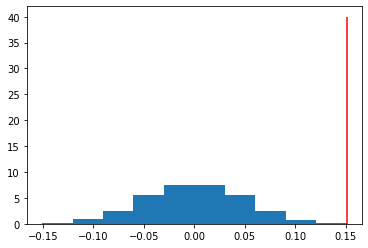

In [23]:
plt.hist(means, density = True)
plt.vlines(obs, ymin = 0, ymax = 40, color = "red")
plt.show()

It is clearly visible in the histogram above that the observed mean difference is significant. But let's compute the p-value anyway (this is a one-sided test since our alternative hypothesis was that the difference is larger than zero)

In [24]:
p_value = (sum(np.array(means)>=obs) + 1)/(len(means)+1)
print("The test gives a p-value of: ", p_value, "\nWe thus reject our null hypothesis")

The test gives a p-value of:  0.0013998600139986002 
We thus reject our null hypothesis
